# Seismic forward modeling with Deepwave, from SEGY to SEGY:

First let's install Deepwave, a 2D/3D acoustic propagator, and SEGYIO/Obspy to read/write Segys. After a fresh install of Ubuntu 20.10, here is the Deepwave install procedure. You may want to use a separate Python environment.

In [ ]:
sudo apt update
sudo apt install python3-pip
wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
chmod +x Miniconda3-latest-Linux-x86_64.sh
./Miniconda3-latest-Linux-x86_64.sh

allow Miniconda to add setup to .bashrc, then restart terminal.

In [ ]:
conda install pytorch torchvision torchaudio cpuonly -c pytorch
conda install scipy
pip install deepwave
pip install segyio
pip install obspy

You can now test Deepwave with test.py from Deepwave's Github repository. It contains the "full example" from forward modelling in the Deepwave README.md. 

Second let's download some public data (from SEG/EAGE) to run our simulation, and unpack it:

In [ ]:
wget http://s3.amazonaws.com/open.source.geoscience/open_data/bpvelanal2004/vel_z6.25m_x12.5m_exact.segy.gz
gunzip vel_z6.25m_x12.5m_exact.segy.gz

This is the BP "tooth model", a nice and simple 2D velocity model used for benchmarks. It is distributed in SEGY.

Let's import the python packages to be used for the simulation, and define a few parameters:

In [18]:
'''
2D acoustic wave equation propagator, using Deepwave

Here we will:
    -define propagator parameters
    -define a shot geometry
    -Load a numpy array with the velocity model previously prepared from a SEGY
    -run the propagator
    -extract shots, resample along the time dimension
    -save the shots in compressed numpy array on disk
    -export the shots to SEGY
'''

import torch
import numpy as np
import scipy
import matplotlib.pyplot as plt
import deepwave
import SEGY_wrapper as wrap

#______________________________________________________________________________
#User parameters: 
    
# Propagator parameters
freq = 12 # source max frequency in Hz
dx = [12.5,12.5] # Float or list of floats containing cell spacing in each dimension ordered as [dz, dy, (dx)]
dt = 0.001 # Propagator time step in s
nt = int(5 / dt) # insert shot length in seconds 
num_dims = 2 #  2D or 3D

# Survey parameters
num_shots = 2 #10
num_sources_per_shot = 1
num_receivers_per_shot = 1000
source_spacing = 800.0 # meters
receiver_spacing = 12.5 # meters

# Compute parameters, CPUs or GPUs
#device = torch.device('cuda:0') # GPU
device = torch.device("cpu") #CPU

#The compressed Numpy array with all the shots, resampled in time
time_decim=6 # decimation of the shots in the time direction before saving shots to disk

Now let's call the SEGY wrapper to load to Numpy a subset of the SEGY we previously downloaded:

C 1  vel_z6.25m_x12.5m_exact.segy
C 2  Exact velocity model
C 3  axis   z    x    y
C 4  size   1911 5395 1
C 5  origin 0    0    0
C 6  delta  6.25 12.5 1
C 7  unit   meter
C 8
C 9  XYScaler=-10
C 10 ElevScaler=-10
C 11
C 12 BP 2004 Velocity Benchmark
C 13
C 14 Read full disclaimer provided with the data.
C 15
C 16 You accept the material as is and assume all responsability
C 17 for the results or use of the material. Any use which you
C 18 make of the materials is at your own risks.
C 19
C 20 BP provides no warranties to you, expressed, implied or statutory,
C 21 including any implied warranties of fitness for a particular purpose.
C 22
C 23 You agree that if you share any or all of this data with any other
C 24 person or organization, you will also include all of the associated
C 25 documentation originally included with the data and provided to you.
C 26
C 27 In no event will BP be liable for any damages, including direct,
C 28 indirect, special, incidental or consequential damages

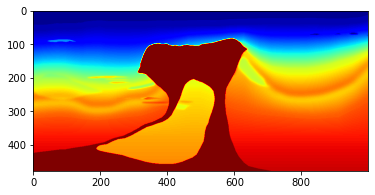

In [19]:
# Load a subset of a SEGY into a NUMPY array using the SEGY Wraper
model_true=wrap.Segy2Numpy('vel_z6.25m_x12.5m_exact.segy',subsetz=(None,None,4),subsety=(2000,4000,2))

The wrapper shows us the EBCDIC header of our SEGY file, the binary header, and some relevant information from the trace header. Then it displays in an image of the subset of the velocity we selected.It returns a numpy array -not a torch tensor, for maximum compatibility with other propagators we may want to wrap, besides Deepwave.

Of course you can get the help and a description of the arguments of the Segy2Numpy function by looping at the docstring as usual:

In [20]:
print(wrap.Segy2Numpy.__doc__)


    Read a SEGY dataset and save a subset (or all of it) into a numpy array.
    Perform diagnostics and QCs. 2D or 3D. 
    If the dataset is 3D, the user should reshape the NumpyArray after calling 
    this function.
    Arguments:
    -segyfile: name or full path to a valid SEGY file
    -subsetz, subsety: slice in the z and y direction, default: selec all
    -verbose: print EBCDIC header, binary header and some trace parameters, default: True
    -pictures: display and save pictures of the full and subset of the segy, default: True
    -savez: save the data in compressed numpy array form on disk, named from SEGY
    


Now let's look in detail at our Numpy array and our parameters:

In [21]:
# Print informations and make pictures for QC
ny = model_true.shape[1] # Number of samples along y
nz = model_true.shape[0] # Number of depth samples, ie nbr samples along z
print("Velocity model Information:")
print("Velocity model size, ny , nz:", ny,nz)
print("Velocity model size in meters, Y and Z:",(ny-1)*dx[1],(nz-1)*dx[0])
Vvmin, Vvmax = np.percentile(model_true, [0,100])
print("Velocity min and max:", Vvmin, Vvmax)
#plt.imshow(model_true, cmap=plt.cm.jet, vmin=Vvmin, vmax=Vvmax)
plt.imsave('velocity_model_for_prop.png',model_true,
           cmap=plt.cm.jet, vmin=Vvmax, vmax=Vvmax)
#Compute stability condition
dtmax=wrap.CourantCondition(dx,num_dims,Vvmax)
print("Grid size:",dx)
print("Time step, number of time samples", dt,nt)
print("Stability condition on the time step dt:",dt,"<",dtmax)

Velocity model Information:
Velocity model size, ny , nz: 1000 478
Velocity model size in meters, Y and Z: 12487.5 5962.5
Velocity min and max: 1429.00024414 4790.0
Grid size: [12.5, 12.5]
Time step, number of time samples 0.001 5000
Stability condition on the time step dt: 0.001 < 0.00184526821813


Here we have called CourantCondition from the wrapper to make sure our simulation satisfies the stability condition.

In [22]:
print(wrap.CourantCondition.__doc__)

Courant–Friedrichs–Lewy stability condition. Find the maximum stable 
    time step allowed by the grid cell size and maximum velocity.


For maximum compatibility the wrapper provides Numpy array, while Deepwave uses Torch tensor, let's convert:

In [23]:
# Convert from NUMPY array to torch tensor
model_true = torch.Tensor(model_true) # Convert to a PyTorch Tensor

Define the survey Geometry:

In [24]:
# Define survey Geometry
# Create arrays containing the source and receiver locations
# x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
# x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing
x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

Define the source waveform:

In [25]:
# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
# I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
# can use whatever Tensor you want as the source amplitude.
source_amplitudes_true = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))

Call the propagator. This is where the magic happens, be patient:

In [26]:
# Propagator call and shot extraction
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_true = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

The time step of the propagator has been defined by the Courant stability condition. The actual time step of the shot output is only limited by the Nyquist condition on the source maximum frequency. So we can (and should) resample the shots, also applying an antialias to remove any unwanted HF due to FDM dispertion. We also convert from torch tensor to Numpy.

In [27]:
# Take all the shots, convert to 3D numpy array, 
# and resample with antialias in the time direction
allshotsresamp=scipy.signal.decimate(receiver_amplitudes_true[:,:].cpu().numpy(), 
                                 time_decim, n=None, ftype='iir', axis=0, zero_phase=True)
#plt.imsave('shotresamp2.png',shotresamp[:,1],cmap=plt.cm.seismic, vmin=-vmax, vmax=vmax)
#np.savez(shotsout,allshotsresamp)# save numpy array to disk

And call the wrapper to export to SEGY:

In [28]:
# Export the shots to SEGY
wrap.Numpy2Segy("FDM_",allshotsresamp, 1000*dt*time_decim)

t_sample,nbr_of_shots,nbr_of_traces: 834 2 1000
Processing Shot: 0
C 1  Synthetic Shot created from Deepwave
    C 2  Velocity used: 
    C 3  Forward modeling parameters:
    C 4  freq = 
    C 5  dx = 
    C 6  dt = 
    C 7  nt = 
    C 8  num_dims = 
    C 9  
    C10  Survey parameters
    C11  num_shots = 
    C12  num_sources_per_shot = 
    C13  num_receivers_per_shot = 
    C14  source_spacing =  # meters
    C15  receiver_spacing =  # meters
    C16
    C17  Compute parameters, CPUs or GPUs
    C18
    C19  device = 
    C20  velname=
    C21  time_decim=
    C22
    C23 
    C24 
    C25 
    C26
    C27 
    C28 
    C29 
    C30 
    C31 
    C32
    C33 
    C34 
    C35 
    C36
    C37 
    C38 
    C39 
    C40 
Binary File Header:
	job_identification_number: 0
	line_number: 0
	reel_number: 0
	number_of_data_traces_per_ensemble: 1
	number_of_auxiliary_traces_per_ensemble: 0
	sample_interval_in_microseconds: 6
	sample_interval_in_microseconds_of_original_field_recording

Again here is the docstring of the Numpy2Segy function:

In [29]:
print(wrap.Numpy2Segy.__doc__)


    Export to SEGY shots generated by a Wave Equation Propgator, eg Deepwave
        -Load the numpy array contaijing all shots generated by the propagator
        -Save one picture per shot
        -Export the shots in from Numpy to SEGY, one SEGY per shot
        
        To export SEGYs we will call SEGYIO through Obspy, 
        which is much easier than SEGYIO when creating segys from scratch.
        
        Arguments:
            -segy_name: radical name or full path + radical to the desired output
            -Shots: numpy array for the shots
            -verbose: print EBCDIC header, binary header and some trace parameters, default: True
            -pictures: display and save pictures of the fshots, default: True
            -EBCDIC: default or custom EBCDIC header
    
    


Now let's QC the shots we just output to SEGY:

![title](Shot_0.png)

![title](Shot_1.png)

A bit of dispersion on the direct arrivals as time increases, but it makes the point.
We can even read the SEGY from scratch to double check it is fine:




{JobID: 0, LineNumber: 0, ReelNumber: 0, Traces: 1, AuxTraces: 0, Interval: 6, IntervalOriginal: 0, Samples: 834, SamplesOriginal: 0, Format: 1, EnsembleFold: 1, SortingCode: 5, VerticalSum: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, Sweep: 0, SweepChannel: 0, SweepTaperStart: 0, SweepTaperEnd: 0, Taper: 0, CorrelatedTraces: 0, BinaryGainRecovery: 0, AmplitudeRecovery: 0, MeasurementSystem: 1, ImpulseSignalPolarity: 1, VibratoryPolarity: 0, ExtAuxTraces: 0, ExtSamples: 0, ExtSamplesOriginal: 0, ExtEnsembleFold: 0, SEGYRevision: 1, SEGYRevisionMinor: 0, TraceFlag: 1, ExtendedHeaders: 0}



Sample rathe: 4.0
Velocity array size: (834, 1000)
Vmin, Vmax -0.15768535018 0.0996628189087


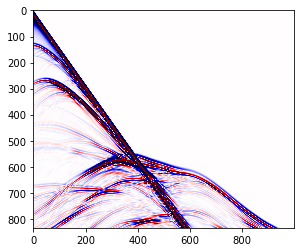

In [32]:
'''
Read a SEGY shot for QC.

'''

# User variables
segyfile = r'Shot_0.sgy'

#______________________________________________________________________________
import matplotlib.pyplot as plt
import segyio
import numpy as np

#______________________________________________________________________________
# Read the Segy with SEGYIO
f = segyio.open(segyfile, ignore_geometry=True)#,endian = 'big')
traces=f.trace.raw[:].T
n_traces = f.tracecount
sample_rate = segyio.tools.dt(f) / 1000
ebcdic_header = segyio.tools.wrap(f.text[0])
bin_headers = f.bin
spec = segyio.tools.metadata(f)
#print(ebcdic_header)
print("\n\n")
print(bin_headers)
print("\n\n")
print("Sample rathe:",sample_rate)
# Find the min and max value in the dataset
print("Velocity array size:",traces.shape)
vmin, vmax = np.percentile(traces, [2,98])
print("Vmin, Vmax", vmin,vmax)

#______________________________________________________________________________
# Plot the data
plt.imshow(traces, cmap=plt.cm.seismic, vmin=-vmax, vmax=vmax)